In [143]:
from converter import *
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import colormaps

In [151]:
import tensorflow_addons as tfa

/Users/maxwatzky/anaconda3/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/maxwatzky/anaconda3/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
I

In [152]:
plt.style.use('ggplot')

In [175]:
# 1) Parameters
IMG_SIZE = (512, 512)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
file_dir = 'tiff_images/'
all_files = tf.io.gfile.listdir(file_dir)

In [237]:
def augment(image, label):
    # 1a. Random rotation by a multiple of 90°
    image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)

    # 1b. Random small rotation (±20°) using tf.image.rotate (requires angles in radians)
    angle = tf.random.uniform([], -20.0, 20.0) * (3.14159265 / 180.0)
    image = tfa.image.rotate(image, angle, fill_mode='reflect')

    # 1c. Add Gaussian noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05)
    image = tf.clip_by_value(image + noise, 0.0, 1.0)
    
    return image, label

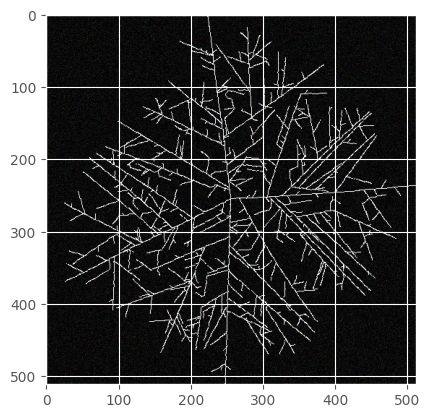

In [238]:
im = plt.imread(file_dir + all_files[0])
(im, _) = augment(im, 1)
plt.imshow(im)

In [239]:
def parse_angle(filename):
    # filename: e.g. "SWC-Sample-1-BrAngle-40.00.swc..tiff"
    parts = tf.strings.split(filename, sep='BrAngle-')
    angle_part = tf.strings.split(parts[-1], sep='.')[0]
    angle = tf.strings.to_number(angle_part, out_type=tf.float32)
    return angle

from PIL import Image
import numpy as np

def _load_tiff_with_pil(path_bytes):
    # path_bytes arrives as an EagerTensor; convert to numpy bytes
    path_str = path_bytes.numpy().decode('utf-8')
    # now open with PIL
    with Image.open(os.path.join(file_dir, path_str)) as img:
        img = img.convert("L").resize(IMG_SIZE)
        arr = np.array(img, dtype=np.float32) / 255.0
    return arr.reshape((*IMG_SIZE, 1))

def load_and_preprocess(fname):
    # fname is a tf.Tensor; tf.py_function will hand _load_tiff_with_pil
    # a numpy scalar so .numpy() works above
    img = tf.py_function(
        func=_load_tiff_with_pil,
        inp=[fname],
        Tout=tf.float32
    )
    img.set_shape([*IMG_SIZE, 1])
    label = parse_angle(fname)
    return img, label

In [240]:
# split your filenames once
n = len(all_files)
train_files = all_files[: int(0.8*n)]
val_files   = all_files[int(0.8*n):]

def make_ds(file_list, shuffle=False, augment_data=False):
    ds = tf.data.Dataset.from_tensor_slices(file_list)
    if shuffle:
        ds = ds.shuffle(len(file_list), seed=1234)

    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    if augment_data:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)

    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Create datasets
train_ds = make_ds(train_files, shuffle=True, augment_data=True)
val_ds   = make_ds(val_files,   shuffle=False, augment_data=False)

In [241]:
val_ds.cardinality().numpy()

44

In [245]:
def build_model():
    return tf.keras.Sequential([
        # input is 512×512 grayscale
        tf.keras.Input(shape=(512, 512, 1)),

        # flatten into a vector of size 512*512=262144
        tf.keras.layers.Flatten(),

        # a few hidden layers
        #tf.keras.layers.Dense(512, activation='relu'),
        #tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        # output angle in [0,1]
        tf.keras.layers.Dense(1, activation='sigmoid'),

        # scale to [0, 180]
        tf.keras.layers.Lambda(lambda x: x * 180.0),
    ])

In [246]:
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)


In [247]:

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
175/175 [==============================] - 54s 305ms/step - loss: 7959.8257 - rmse: 89.2179 - val_loss: 8039.1431 - val_rmse: 89.6613
Epoch 2/20
118/175 [===================>..........] - ETA: 14s - loss: 7955.1909 - rmse: 89.1919

KeyboardInterrupt: 

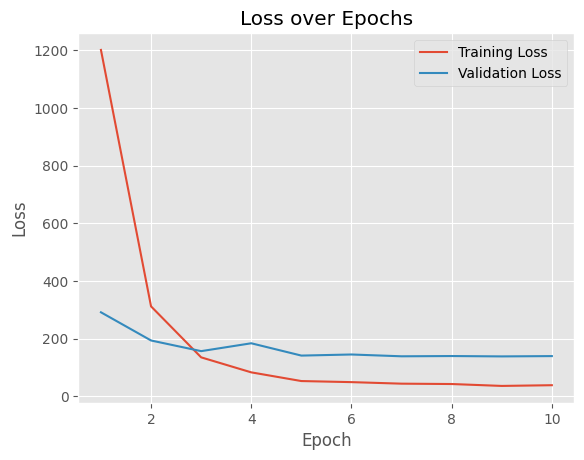

In [125]:
loss       = history.history['loss']
val_loss   = history.history.get('val_loss')

epochs = range(1, len(loss) + 1)

# --- Plot Loss ---
plt.figure()
plt.plot(epochs, loss, label='Training Loss')
if val_loss is not None:
    plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [126]:
y_true = np.concatenate([y.numpy().astype(int) for x, y in val_ds], axis=0)
y_pred_continuous = model.predict(val_ds).flatten()

44/44 [==============================] - 14s 317ms/step


In [127]:
indices = np.argsort(y_true)
y_true = y_true[indices]
y_pred_continuous = y_pred_continuous[indices]
color = (y_true - 20) / (140 - 20)

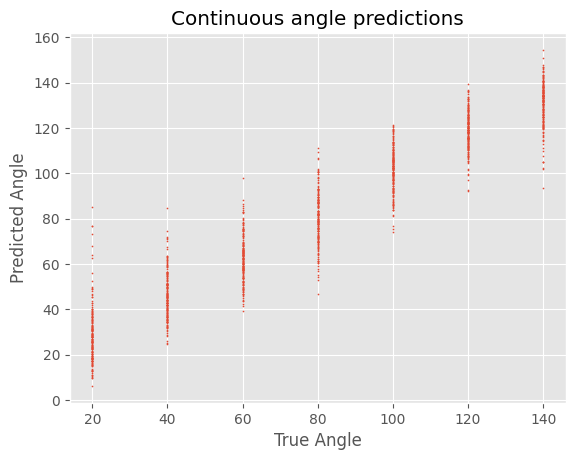

In [128]:
plt.scatter(y_true, y_pred_continuous, s= 0.5)
plt.xlabel("True Angle")
plt.ylabel("Predicted Angle")
plt.title("Continuous angle predictions")
plt.savefig("continuous.png")

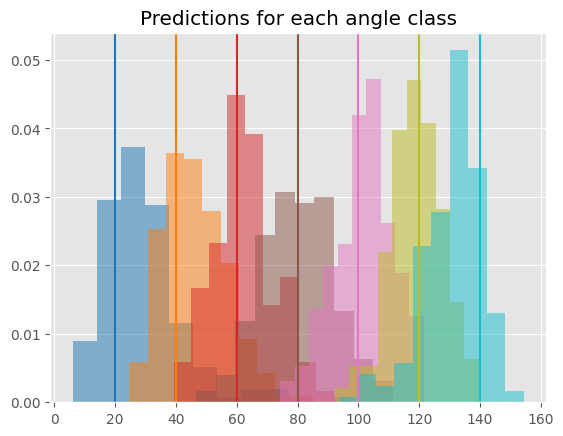

In [129]:
cmap = plt.cm.tab10
for ind_color in np.unique(color):
    plt.hist(y_pred_continuous[np.where(color == ind_color)], color = cmap(ind_color), alpha = 0.5, density = True)
    plt.axvline(ind_color * (140 - 20) + 20, color = cmap(ind_color))
plt.title("Predictions for each angle class")

plt.savefig("preds.png")

In [130]:
errors = y_pred_continuous - y_true
from scipy.stats import norm
(mu, sigma) = norm.fit(errors)

x = np.arange(-50, 50, 0.1)
A = 1/(sigma * np.sqrt(2*np.pi))
y = A * np.exp((-1/2) * ((x - mu) / sigma)**2)

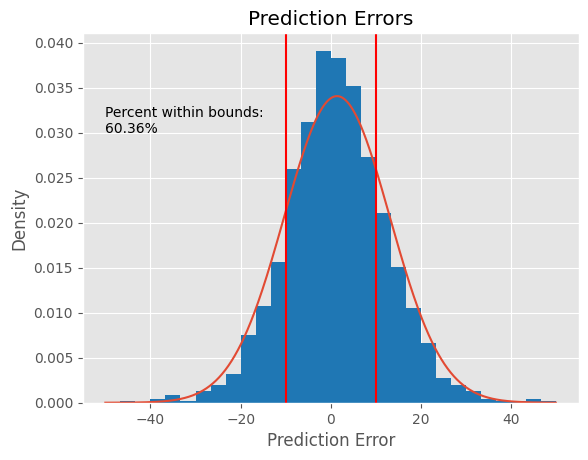

In [131]:
plt.hist(errors, bins = 30, range = [-50, 50], density = True, color = cmap(0))
plt.plot(x, y)
plt.axvline(-10, c = "red")
plt.axvline(10, c = "red")
plt.ylabel("Density")
plt.xlabel("Prediction Error")
plt.title("Prediction Errors")

p = norm.cdf(10, loc=mu, scale=sigma) - norm.cdf(-10, loc=mu, scale=sigma)
percent = p * 100
plt.text(-50, .03, "Percent within bounds: \n" + str(round(percent, 2)) + "%")
plt.savefig("pred_errors.png")